In [260]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matrix_factorization import matrix_factorization
from graph_init import *
from similarity import *
from create_R import *
from ALS import *
from hard_hfs import *
import copy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
def RMSE(ground, predict):
    
    error = 0
    n = 0
    
    for i in range(len(ground)):
        for j in range(len(ground[0])):
            if ground[i,j] != 0:
                error += (ground[i,j] - predict[i,j])**2
                n += 1
                
    return np.sqrt(error/n)

def RMSEvec(ground, predict):
    
    error = 0
    n = 0
    
    for i in range(len(ground)):
        if ground[i] != 0:
            error += (ground[i] - predict[i])**2
            n += 1
                
    return np.sqrt(error/n)

def meanError(ground_truth,new_res):
    return np.mean(abs((new_res - ground_truth)[ground_truth!=0]))

def dictfromR(R):

    R_dict = {"Users": np.empty([0]), "Movies": np.empty([0]), "Ratings": np.empty([0])}

    for i in range(len(R)):
        for j in range(len(R[0])):
            if R[i,j] != 0:
                R_dict["Users"] = np.append(R_dict["Users"],i)
                R_dict["Movies"] = np.append(R_dict["Movies"],j)
                R_dict["Ratings"] = np.append(R_dict["Ratings"],R[i,j])

    return R_dict

In [262]:
R,R_dict = create_R()

print(R_dict)

/home/marc/Documents/MVA/ProjetGraphes/src/create_R.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  R[ratingsnp[i,0]-1, ratingsnp[i,-1]] = ratingsnp[i,2]


{'Ratings': array([ 2.5,  3. ,  3. , ...,  4. ,  2.5,  3.5]), 'Users': array([   0.,    0.,    0., ...,  670.,  670.,  670.]), 'Movies': array([   30.,   833.,   859., ...,  4597.,  4610.,  4696.])}


In [263]:
P_dict = copy.deepcopy(R_dict)
P_dict["Ratings"] = np.ones([len(R_dict["Ratings"])])
P = R > 0
print(P)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [ True False False ..., False False False]
 [ True False False ..., False False False]]


In [264]:
to_keep = 99.85/100

iss, js = np.where(R > 0.1)
n_ratings = len(js)
ground_truth = copy.deepcopy(R)
shuf = np.array(range(n_ratings))
iss = iss[shuf]
js = js[shuf]

deleted_i = []
deleted_j = []
deleted = 0
i = 0
while deleted < len(iss)*(1-to_keep):
    if np.sum(R[iss[i]] > 0.1) > 1 and np.sum(R[:,js[i]] > 0.1) > 1:
        R[iss[i],js[i]] = 0
        deleted += 1
        deleted_i.append(iss[i])
        deleted_j.append(js[i])
    i += 1
        
    
# deleted_i = iss[:len(iss)*(1-to_keep)]
# deleted_j = js[:len(js)*(1-to_keep)]
# R[deleted_i, deleted_j] = 0

In [265]:
np.mean(R[R != 0])

3.5437993850960914

In [266]:
R_dictCopy = copy.deepcopy(R_dict)
R_dict = dictfromR(R)

In [267]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],3.55*np.ones(len(deleted_i))))

0.929207809006


In [112]:
N = len(R)
M = len(R[0])
K = 4

als = ALS(K,N,M,"Users","Movies","Ratings",lbda = 0.1,lbda2 = 0.1)
print("Als created")
ans = als.fit(R_dict)

Als created


In [113]:
R_rec = np.dot(als.U,np.transpose(als.V))

In [114]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_rec[deleted_i,deleted_j]))

4.11149823383


In [115]:
R_rec[deleted_i,deleted_j]

array([  2.29700832e+00,   2.76217137e+00,   2.60425165e+00,
         2.47738546e+00,   2.94912485e+00,   2.91459307e+00,
         2.88271487e+00,   3.01562477e+00,   2.43390917e+00,
         2.71487981e+00,   2.21470134e+00,   2.33572217e+00,
         2.89259165e+00,   2.47322566e+00,   2.56385035e+00,
         2.44990704e+00,   2.46034045e+00,   2.56659376e+00,
         2.74186580e+00,   2.55110723e+00,   3.48679975e+00,
         3.12108784e+00,   2.98175593e+00,   3.49128958e+00,
         3.04289626e+00,   2.94288669e+00,   3.10820129e+00,
         2.98123225e+00,   3.23647658e+00,   2.16114459e+00,
         2.88611052e+00,   2.37032158e+00,   2.40893741e+00,
         2.29817837e+00,   2.03613858e+00,   2.05343990e+00,
         3.08862444e+00,   3.13599319e+00,   2.34395586e+00,
         3.05137409e+00,   2.25054251e+00,   2.45278708e+00,
         3.31962215e+00,   3.21187618e+00,   2.80992392e+00,
         3.38475186e+00,   2.48840992e+00,   2.38070646e+00,
         3.35124536e+00,

In [116]:
lp = LaplacianParams()

# sim = similarity(als.U)
sim = build_graph(als.U, GraphParams())
# Seems to work better with U... 
L = build_laplacian(sim,lp)

In [117]:
lhfs = []
lconf = []
for i in range(len(R[0])):
    if i%1000 == 0:
        print(i)
    hfs0, confidence = simple_hfs(als.U, R[:,i]*2, L, sim)
    maxconfidences = np.array([max(confidence[i,:]) for i in range(len(confidence))])
    
    lim = np.percentile(maxconfidences, 90)
    
    lhfs.append(hfs0/2)
    lconf.append(maxconfidences > lim)

R_barre = np.vstack(lhfs).T
confs = np.vstack(lconf).T

0


/home/marc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


1000
2000
3000
4000
5000
6000
7000
8000
9000


In [118]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_barre[deleted_i,deleted_j]))

1.33119486631


In [119]:
R_barre_limited = R_barre * confs
R_barre_final = copy.deepcopy(R_barre_limited)
R_barre_final[R != 0] = 0
# R_dict_barre = dictfromR(R_barre_final)

In [120]:
N = len(R)
M = len(R[0])
K = 1

als_trans = ALS(K,N,M,"Users","Movies","Ratings",lbda = 0.1,lbda2 = 0.1)
print("Als created")
ans = als_trans.fitTransductive(R_dict,R_barre_final,C1=1,C2=.1)

R_rec_trans = np.dot(als_trans.U,np.transpose(als_trans.V))

Als created


In [121]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_rec_trans[deleted_i,deleted_j]))

1.21227852531


In [268]:
enleves = np.array([10, 30, 5, 5, 1, 0.1, 0.01, 20, 1, 0.5, 0.5, 0.1, 0.2, 0.01, 0.05, 0.3, 0.4, 0.25, 0.15, 0.35])
RMSEhfs = np.array([1.32674374885, 1.30905728547, 1.44788836719, 1.4249715405, 1.43950610356,1.26059863196, 1.78376517003, 1.3206959484, 1.35854861733, 1.39001285193, 1.52719852323, 1.06357327853, 1.08529290817, 1.28805702866, 1.23867418052, 
1.1801936887, 1.48496202627, 1.13833946302, 1.15589476823, 1.33119486631]) #HFS
RMSErand = np.array([1.10827678053, 1.06910116524, 1.21354273217, 1.21354273217, 1.05455697314, 0.998278220708, 1.16881836212, 1.06500160262, 1.05455697314, 1.05057013321, 1.05057013321, 0.998278220708, 1.02676253025, 1.16881836212, 1.08760845752, 1.09035716054, 1.0698806655, 1.08158711036, 0.929207809006, 1.11193665912]) #Constant
RMSEals = np.array([3.34103109698, 3.6567784054, 3.11900504497, 3.36009286288, 2.97774025308,1.06654905746, 0.91409271283, 3.48617106862, 4.30114920462, 3.04552449344, 3.81279272213, 0.915592088969, 2.02556708006, 0.80595040701, 0.957383505365, 1.08584093858, 4.44853531724, 1.83389908845, 2.82346349481, 4.11149823383]) #ALS
RMSEtrans = np.array([1.29307089433,1.32952142571, 1.32641438877, 1.43307918684, 1.62984802727, 1.07843682215, 0.95859828853, 1.27306921394, 1.71125206849, 1.31887592815, 1.14583621658, 0.947932371713, 0.878965723091, 1.1518595346,0.994812640054, 0.930838724808, 1.08594083348, 0.864330876328, 0.886734080467, 1.21227852531]) #Transductive

<b>Transductive</b>

10% - 1 - 0.1 - 1.29307089433 

5% - 1 - 0.1 - 1.32641438877 

5% - 1 - 1   - 1.43307918684 

1% - 1 - 0.1   - 1.62984802727 

0.1% - 1 - 0.1   - 1.07843682215 

0.01% - 1 - 0.1   - 0.95859828853 

20% - 1 - 0.1 - 1.27306921394 

30% - 1 - 0.1 - 1.32952142571

1% - 1 - 0.1 - 1.71125206849

.5% - 1 - 0.1 - 1.31887592815

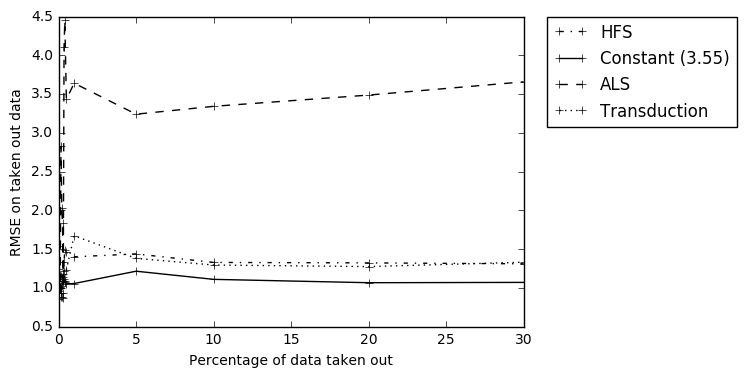

In [271]:
plt.plot(np.unique(enleves), [np.mean(RMSEhfs[np.where(enleves == i)]) for i in np.unique(enleves)], "k-.+", label = "HFS")
plt.plot(np.unique(enleves), [np.mean(RMSErand[np.where(enleves == i)]) for i in np.unique(enleves)], "k-+", label = "Constant (3.55)")
plt.plot(np.unique(enleves), [np.mean(RMSEals[np.where(enleves == i)]) for i in np.unique(enleves)], "k--+", label = "ALS")
plt.plot(np.unique(enleves), [np.mean(RMSEtrans[np.where(enleves == i)]) for i in np.unique(enleves)], "k:+", label = "Transduction")

plt.xlabel("Percentage of data taken out")
plt.ylabel("RMSE on taken out data")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

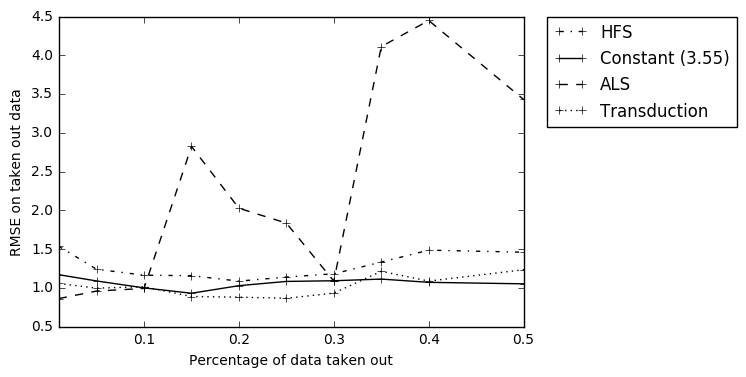

In [272]:
plt.plot(np.unique(enleves), [np.mean(RMSEhfs[np.where(enleves == i)]) for i in np.unique(enleves)], "k-.+", label = "HFS")
plt.plot(np.unique(enleves), [np.mean(RMSErand[np.where(enleves == i)]) for i in np.unique(enleves)], "k-+", label = "Constant (3.55)")
plt.plot(np.unique(enleves), [np.mean(RMSEals[np.where(enleves == i)]) for i in np.unique(enleves)], "k--+", label = "ALS")
plt.plot(np.unique(enleves), [np.mean(RMSEtrans[np.where(enleves == i)]) for i in np.unique(enleves)], "k:+", label = "Transduction")

plt.xlabel("Percentage of data taken out")
plt.ylabel("RMSE on taken out data")

plt.xlim(xmin = 0.01, xmax = 0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()